In [1]:
from data import Data
import numpy as np
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
d = Data(first=10)
X_train,y_train = d.get_10()
X_cross, y_cross = d.get_dev()
X_test,y_test = d.get_test()

In [3]:
X_train = X_train.transpose(0, 3, 1, 2)
y_train = y_train
print(X_train.shape)
print(y_train.shape)
print(X_cross.shape)
print(y_cross.shape)
print(X_test.shape)
print(y_test.shape)
# print(list(y_train))

(20, 3, 128, 128)
(20,)
(4, 128, 128, 3)
(4,)
(3, 128, 128, 3)
(3,)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [5]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [6]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        img = self.X[index]
        label = self.y[index]
        return (img, label)

    def __len__(self):
        return self.X.shape[0]

In [7]:
NUM_TRAIN = X_train.shape[0]
train_dataset = MyCustomDataset(X_train, y_train)
loader_train = DataLoader(train_dataset, batch_size=10,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

test_dataset = MyCustomDataset(X_test, y_test)
loader_test = DataLoader(test_dataset, batch_size=10)

In [8]:
def flatten(X):
    N = X.shape[0]
    return X.view(N,-1)

In [9]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(Variable(x.float()))
            _, preds = scores.max(1)
            num_correct += (preds == Variable(y.long())).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [10]:
print_every = 10
def train(model, optimizer, epochs=6):
    loss_arr = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            scores = model(Variable(x.float()))
            loss = F.cross_entropy(scores, Variable(y.long()))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss))
                loss_arr += [loss.item()]
                check_accuracy(loader_train, model)
    return loss_arr

In [11]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

Iteration 0, loss = 34.0476
Got 7 / 20 correct (35.00)
Iteration 0, loss = 141.8401
Got 10 / 20 correct (50.00)
Iteration 0, loss = 44.4205
Got 10 / 20 correct (50.00)
Iteration 0, loss = 39.3795
Got 10 / 20 correct (50.00)
Iteration 0, loss = 81.9609
Got 10 / 20 correct (50.00)
Iteration 0, loss = 12.2721
Got 16 / 20 correct (80.00)


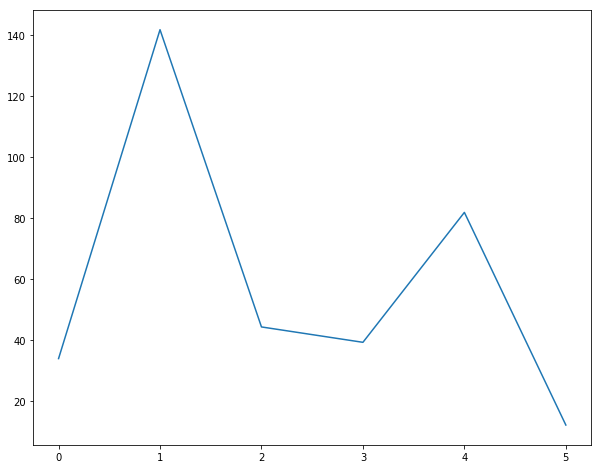

In [14]:
# hidden_layer_size = 500
# for i in range(20):
#     plt.subplot(4, 5, i+1)
#     print (X_train[i].transpose(1,2,0).shape)
#     imshow_noax(X_train[i].transpose(1,2,0), normalize=False)
#     print(y_train[i])

plt.show()
channel_1 = 16
channel_2 = 32
learning_rate = 5e-5
num_classes = 2

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 128 * 128, 10)
) 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_arr = train(model,optimizer)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.plot(loss_arr)
plt.show()